<a href="https://colab.research.google.com/github/JA4S/JANC/blob/main/examples/1D/Chapman-Jouguet/1D_CJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install JANC and import relevant libraries

In [ ]:
# Copyright © 2025 Haocheng Wen, Faxuan Luo
# SPDX-License-Identifier: MIT

!pip install git+https://github.com/JA4S/JANC.git

  Cloning https://github.com/luofx23/JANC.git to /tmp/pip-req-build-vfe2q963
  Running command git clone --filter=blob:none --quiet https://github.com/luofx23/JANC.git /tmp/pip-req-build-vfe2q963
  Resolved https://github.com/luofx23/JANC.git to commit 98492c7d11e8ecbde6b5aae2ba9d3f461059ba57
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/JA4S/JAX-AMR.git to /tmp/pip-install-zs4i04md/jaxamr_01f9977832454a6faaa030908e2e94ff
  Running command git clone --filter=blob:none --quiet https://github.com/JA4S/JAX-AMR.git /tmp/pip-install-zs4i04md/jaxamr_01f9977832454a6faaa030908e2e94ff
  Resolved https://github.com/JA4S/JAX-AMR.git to commit 8f58334fe3f182fe175b6d7aecf7a0fc3e5beed0
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 58.1 MB/s eta 0:00:00
  Created whe

In [ ]:
from janc_v2.model import thermo_model
from janc_v2.simulation import set_simulator
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# set JAX to use GPU
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# Example : 1D Chapman-Jouguet Detonation Tube

# Set nondimension parameters and grid

In [ ]:
#grid config
Lx = 50
nx = 15000
dx = Lx/nx
grid_config = {'dx':dx}


#thermo_config
R = 1.0
gamma = 1.29
thermo_config = {'thermo_model':'constant_gamma',
          'gas_constant':R,
          'gamma':gamma}
thermo_model.set_thermo(thermo_config)


#reaction_config
#user-defined reaction source terms
k = 934.7160 #pre-exponential factor
Q = 24.6   #heat release rate
Ea = 11.5   #activation energy
Tc = 1.05   #ignition tempreature
def source(U,aux,theta):
  T = aux[-1]
  alpha = jnp.sqrt(gamma)*(2/(gamma+1))**((gamma+1)/(2*(gamma-1)))
  rho, rho_u, E, rho_z = U
  z = rho_z / rho

  omega = (T>Tc) * k * rho * (1 - z) * jnp.exp(- Ea / T)
  f1 = jnp.zeros_like(rho)
  f2 = jnp.zeros_like(f1)
  f3 = omega*Q
  f4 = omega
  f = jnp.stack([f1, f2, f3, f4], axis=0)  # 合并通量

  return f
reaction_config = {'is_detailed_chemistry':False,
           'self_defined_reaction_source_terms':source
           }
#flux_config
flux_config = {'solver_type':'flux_splitting',
        'interface_reconstruction':'WENO5_JS',
        'split_method':'LF',
        'viscosity':'off'
        }

# Set boundary conditions

In [ ]:
boundary_config = {'left_boundary': 'slip_wall',
           'right_boundary': 'zero-gradient'}

# Initializations

In [ ]:
time_control = {'temporal_evolution_scheme':'RK2',
         'CFL':0.20,
         't_end':8.0}
output_settings = {'save_dt':2.0,
          'results_path':'results.h5'}
computation_config = {'output_settings':output_settings}
simulation_config = {'dimension':'1D',
            'grid_config':grid_config,
            'thermo_config':thermo_config,
            'reaction_config':reaction_config,
            'flux_config':flux_config,
            'boundary_config':boundary_config,
            'time_config':time_control,
            'computation_config':computation_config}
Simulator = set_simulator.Simulator(simulation_config)

In [ ]:
def initial_conditions(P0,T0):
    P_init = jnp.full((1,nx),P0)
    T_init = jnp.full((1,nx),T0)
    T_init = T_init.at[:,0].set(5.0)
    rho_init = P_init/(R*T_init)
    rhou_init = jnp.zeros((1,nx))
    E_init = P_init/(gamma-1)
    rhoz_init = jnp.zeros((1,nx))
    U_init = jnp.concatenate([rho_init,rhou_init,E_init,rhoz_init],axis=0)
    gamma_init = jnp.full_like(rho_init,gamma)
    aux_init = jnp.concatenate([gamma_init,T_init],axis=0)
    return U_init,aux_init
P0 = 0.5
T0 = 1.0
U, aux = initial_conditions(P0,T0)
x = jnp.linspace(0, Lx, nx)

# Main loop of time advance

In [ ]:
U_final, aux_final, t_final = Simulator.run(U,aux)

Simulation: 100%|██████████| 8.0/8.0 [01:31<00:00]


# Postprocess
Compare the solution with analytical results

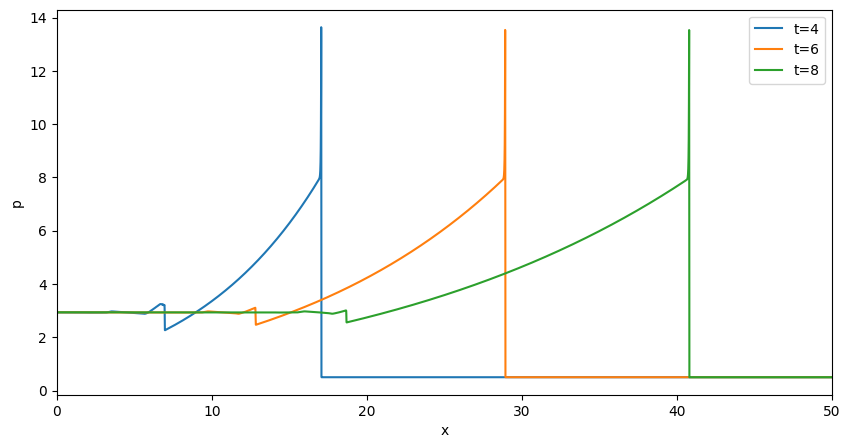

In [ ]:
#t = 4.0
time_4, state_dict = Simulator.saver.load('save_step2')
p_4 = state_dict['pressure']
T_4 = state_dict['tempreature']

#t = 6.0
time_6, state_dict = Simulator.saver.load('save_step3')
p_6 = state_dict['pressure']
T_6 = state_dict['tempreature']

#t = 8.0
time_8, state_dict = Simulator.saver.load('save_step4')
p_8 = state_dict['pressure']
T_8 = state_dict['tempreature']
u_8 = state_dict['x-velocity']

plt.figure(figsize=(10,5))
plt.plot(x,p_4,x,p_6,x,p_8)
plt.legend(['t=4','t=6','t=8'])
plt.xlim(0,Lx)
plt.xlabel('x')
plt.ylabel('p')
plt.show()

metric1: CJ speed

In [ ]:
#wave speed
index1 = np.argmax(p_8)
index2 = np.argmax(p_6)
D = (index1-index2)*dx/(time_8-time_6)
M = D/np.sqrt(gamma*R*T0)

#CJ speed
MCJ = np.sqrt(1+Q*(gamma**2-1)/(2*gamma))+np.sqrt(Q*(gamma**2-1)/(2*gamma))
error = (np.abs(MCJ-M)/MCJ)*100

print(f'relative error of CJ speed:{error:.3f}%')

relative error of CJ speed:0.028%


metric2: VN state

In [ ]:
#VN state
p_ratio = np.max(p_8)/P0

#theoretical
p_ratio_r = 1+2*gamma/(gamma+1)*(MCJ**2-1)
error = 100*np.abs(p_ratio_r-p_ratio)/p_ratio_r

print(f'relative error of VN state (pressure):{error:.3f}%')

relative error of VN state (pressure):11.613%


metric3: CJ state

In [ ]:
#CJ state
ur = u_8 - D
Mr = np.abs(ur/np.sqrt(gamma*R*T_8))
index = np.argmin(np.abs(Mr-1.0))
p_ratio = p_8[index]/P0
T_ratio = T_8[index]/T0
rho_ratio_r = 1+1/gamma
T2 = 2*gamma**2/(1+gamma)*(T0 + Q/(gamma/(gamma-1)))
T_ratio_r = T2/T0
p_ratio_r = rho_ratio_r*T_ratio_r
error = 100*np.abs(p_ratio_r-p_ratio)/p_ratio_r
print(f'relative error of CJ state (pressure):{error:.3f}%')

relative error of CJ state (pressure):6.112%
